<h3><b>Project Title : <mark>&nbspElectricity Demand Forecasting and Analysis
Using ARIMA&nbsp</mark></b></h3><br>

## <h3><b>Loading necessary Libraries / Packages</b></h3>

In [21]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
from pandas import DataFrame
from pandas import concat
import numpy as np
from math import sqrt

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
# from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
# from scipy.stats import boxcox
from scipy.special import boxcox, inv_boxcox

import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from matplotlib import colors
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## <h3><b>Mounting the Drive</b></h3>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## <h3><b>Loading and Extracting Appropriate Data</b></h3>

In [4]:
df_power = pd.read_csv("drive/Othercomputers/My Laptop/CAPSTONE PROJECT/CSV_PowerSchedule - Unchahar(4) - Client States.csv")
df_power

,Time Block,Time Desc,UNCHAHAR4,CHANDIGARH_UT,HARYANA_STATE,HIMACHAL_STATE,JK&LADAKH_UT,PUNJAB_STATE,RAJASTHAN_STATE,UTTARAKHAND_STATE,UTTARPRADESH_STATE
0,1,00:00-00:15,257.81,163.648608,2919.185045,898.471638,2463.055559,1974.661967,3464.078710,1227.060154,5707.888517
1,2,00:15-00:30,257.81,161.082531,2737.499105,898.471638,2443.905559,1931.031388,3474.577758,1201.031663,5118.275335
2,3,00:30-00:45,257.81,159.468834,2734.830379,891.722275,2428.118206,1896.707268,3357.696185,1159.794583,4695.923110
3,4,00:45-01:00,257.81,159.008397,2790.660379,891.722275,2418.538206,1901.877753,3157.872520,1153.094583,4785.328445
4,5,01:00-01:15,257.81,158.558834,2688.680379,891.722275,2380.228206,2138.280414,3067.126185,1178.954583,4997.936018
...,...,...,...,...,...,...,...,...,...,...,...
91,92,22:45-23:00,257.81,199.157260,3144.174897,1062.071746,2711.687438,2075.055469,3954.582035,1393.394830,6690.249163
92,93,23:00-23:15,257.81,197.907556,3149.252781,957.793316,2661.538508,2227.478591,3950.086806,1348.067944,5881.705452
93,94,23:15-23:30,257.81,198.145115,3144.109508,930.094679,2607.500621,2235.257041,3858.999919,1281.391341,5719.366297
94,95,23:30-23:45,257.81,169.357366,3132.282000,960.620107,2630.788986,2501.045239,3567.664726,1247.696984,5731.153531


In [5]:
# let us see the General information of the dataset

df_power.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Time Block          96 non-null     int64  
 1   Time Desc           96 non-null     object 
 2   UNCHAHAR4           96 non-null     float64
 3   CHANDIGARH_UT       96 non-null     float64
 4   HARYANA_STATE       96 non-null     float64
 5   HIMACHAL_STATE      96 non-null     float64
 6   JK&LADAKH_UT        96 non-null     float64
 7   PUNJAB_STATE        96 non-null     float64
 8   RAJASTHAN_STATE     96 non-null     float64
 9   UTTARAKHAND_STATE   96 non-null     float64
 10  UTTARPRADESH_STATE  96 non-null     float64
dtypes: float64(9), int64(1), object(1)
memory usage: 8.4+ KB


In [6]:
# Now, we create a new dataframe with all the required I/P attributes

# Here, we are more interested in witnessing the power demand for the state
# of Uttar Pradesh(48.238 %) and Rajasthan (23.378 %) - MAJOR BUYERS !
# SOURCE : Northern Regional Power Committee (Govt. of India)

data = df_power.filter(['UNCHAHAR4'])

## <h3><b>Rolling Statistics</b><h3>
Plotting the data is the initial step in every data analysis assignment. Graphs make it possible to see a variety of data characteristics, such as patterns, peculiar findings, changes through time, and correlations between variables. The forecasting techniques that will be utilised must thus, to the greatest extent feasible, take into account the characteristics that can be observed in plots of the data.

A moving average, also known as a rolling average or running average, is a method used in statistics to examine data points by averaging many subsets of the entire data set.

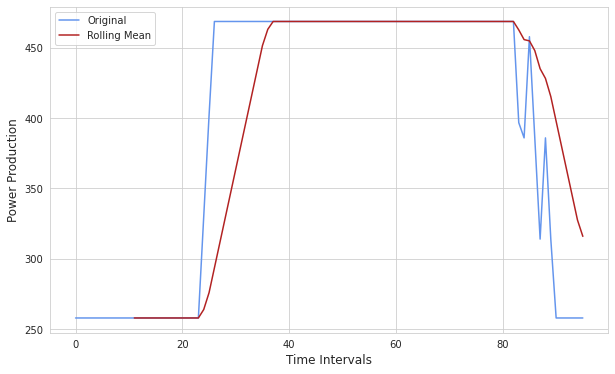

In [7]:
rolling_mean = data.rolling(window=12).mean()
rolling_std = data.rolling(window=12).std()
plt.figure(figsize = (10,6))
plt.plot(data, color='cornflowerblue', label='Original')
plt.plot(rolling_mean, color='firebrick', label='Rolling Mean')

plt.xlabel('Time Intervals', size = 12)
plt.ylabel('Power Production', size  = 12)
plt.legend(loc = 'upper left')

plt.show()

## <h3><b> Checking Stationarity</b></h3>
A time series is said to be stationary if its statistical characteristics, or rather the method used to create it, do not vary over time.

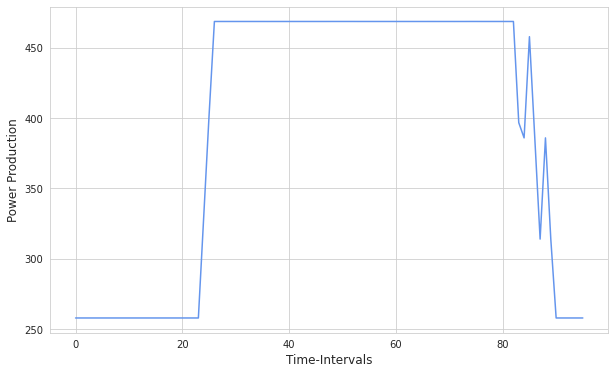

In [8]:
plt.figure(figsize = (10,6))
plt.plot(data, color = 'cornflowerblue')
plt.xlabel('Time-Intervals', size = 12)
plt.ylabel('Power Production', size = 12)
plt.show()

In [9]:
print("Data Shape: {}".format(data.shape))
value_1 = data[0:47]
value_2 = data[48:95]

Data Shape: (96, 1)


We will proceed by splitting the data into two parts so that we can then check the **mean** and **variance** of the data.

<a id = "5"></a><h1 id="Mean of Data"><p style="font-weight: bold; font-family:Verdana; font-size:18px; color:#47A8EC; ">Mean of Data</p></h1>

In [10]:
print("Mean of value_1: {}".format(round(value_1.mean()[0],3)))
print("Mean of value_2: {}".format(round(value_2.mean()[0],3)))

Mean of value_1: 356.655
Mean of value_2: 432.673


<a id = "6"></a><h1 id="Variance"><p style="font-weight: bold; font-family:Verdana; font-size:18px; color:#47A8EC; ">Variance of Data</p></h1>

In [11]:
print("Variance of value_1: {}".format(round(value_1.var()[0],3)))
print("Variance of value_2: {}".format(round(value_2.var()[0],3)))

Variance of value_1: 10893.847
Variance of value_2: 5111.329


## <h3><b>Augmented Dickey-Fuller Test (ADF Test)</b></h3>

Augmented Dickey-Fuller Test is a common statistical test used to test whether a given time series is stationary or not. We can achieve this by defining the null and alternate hypothesis.

**Null Hypothesis:** Time Series is non-stationary. It gives a time-dependent trend.   
**Alternate Hypothesis:** Time Series is stationary. In another term, the series doesn’t depend on time.   

**ADF or t Statistic < critical values:** Reject the null hypothesis, time series is stationary.   
**ADF or t Statistic > critical values:** Failed to reject the null hypothesis, time series is non-stationary.

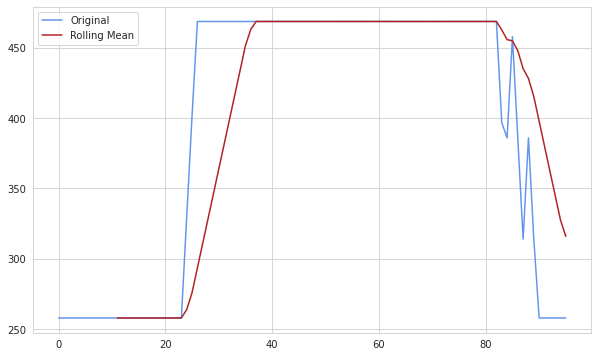


ADF Statistic: -1.753
p-value: 0.404
------------------------------------
Critical Values:
1%: -3.504
5%: -2.894
10%: -2.584
------------------------------------
ADF > Critical Values
Failed to reject null hypothesis, time series is non-stationary.


In [12]:
def adfuller_test(ts, window = 12):
    
    movingAverage = ts.rolling(window).mean()
    movingSTD = ts.rolling(window).std()
    
    plt.figure(figsize = (10,6))
    orig = plt.plot(ts, color='cornflowerblue',
                    label='Original')
    mean = plt.plot(movingAverage, color='firebrick',
                    label='Rolling Mean')
    # std = plt.plot(movingSTD, color='limegreen',
    #                label='Rolling Std')
    plt.legend(loc = 'upper left')
    # plt.title('Rolling Statistics', size = 14)
    plt.show(block=False)
    
    adf = adfuller(ts, autolag='AIC')
    
    print('\nADF Statistic: {}'.format(round(adf[0],3)))
    print('p-value: {}'.format(round(adf[1],3)))
    print("------------------------------------")  
    print('Critical Values:')
    
    for key, ts in adf[4].items():
         print('{}: {}'.format(key, round(ts,3)))
    print("------------------------------------")
    
    if adf[0] > adf[4]["5%"]:
        print("ADF > Critical Values")
        print ("Failed to reject null hypothesis, time series is non-stationary.")
    else:
        print("ADF < Critical Values")
        print ("Reject null hypothesis, time series is stationary.")
        
adfuller_test(data, window = 12)

## <h3><b>Converting Data to Stationary</b></h3>
<h5>Logarithmic Transformation with Box-Cox</h5>
The Box-Cox transform is a configurable data transform method that supports both square root and log transform, as well as a suite of related transforms.

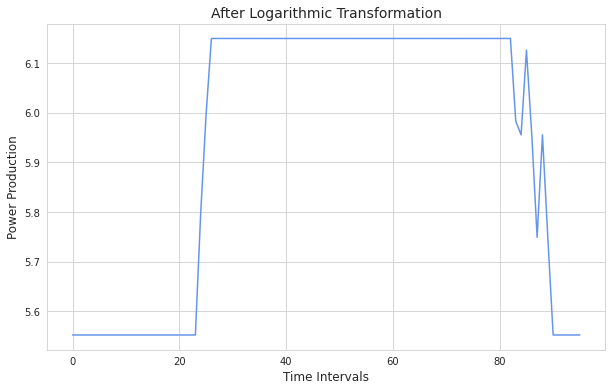

In [13]:
data_log_scaled = data
# data_log_scaled['UNCHAHAR4'] = boxcox(data_log_scaled['UNCHAHAR4'], lmbda=0.0)
data_log_scaled['UNCHAHAR4'] = boxcox(data_log_scaled['UNCHAHAR4'], 0.0)
plt.figure(figsize = (10,6))
plt.plot(data_log_scaled, color = 'cornflowerblue')
plt.xlabel('Time Intervals', size = 12)
plt.ylabel('Power Production', size = 12)
plt.title("After Logarithmic Transformation", size = 14)
plt.show()

## <h3><b>Removing Trend with Moving Average</b></h3>

<b>`Non-stationary`</b> time series are those that exhibit a trend.

It is possible to simulate a discovered trend. It may be taken out of the time series dataset after modelling. Detrending the time series is what this is known as.

A dataset is referred to as trend stationary if it lacks a trend or if the trend can be successfully eliminated.

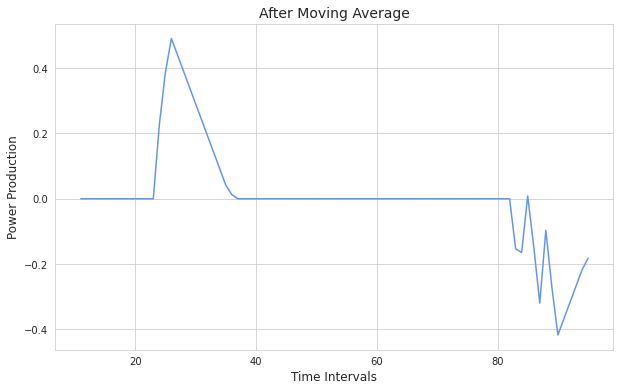

In [14]:
moving_avg = data_log_scaled.rolling(window=12).mean()
data_log_scaled_ma = data_log_scaled - moving_avg
data_log_scaled_ma.dropna(inplace=True)
plt.figure(figsize = (10,6))
plt.plot(data_log_scaled_ma, color = 'cornflowerblue')
plt.xlabel('Time Intervals', size = 12)
plt.ylabel('Power Production', size = 12)
plt.title("After Moving Average", size = 14)
plt.show()

## <h3><b>Exponential Decay Transformation</b></h3>

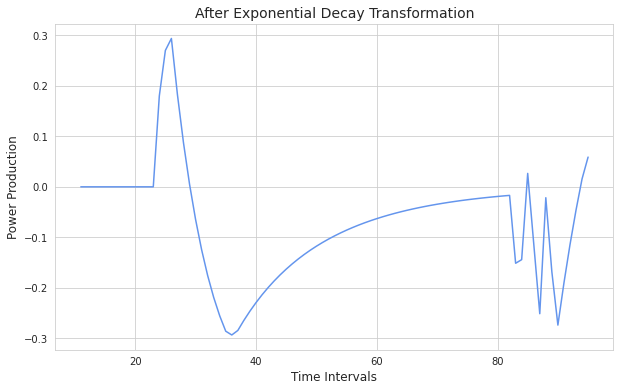

In [15]:
data_log_scaled_ma_ed = data_log_scaled_ma.ewm(halflife=12, min_periods=0, adjust=True).mean()
data_lsma_sub_data_lsma_ed = data_log_scaled_ma - data_log_scaled_ma_ed
plt.figure(figsize = (10,6))
plt.plot(data_lsma_sub_data_lsma_ed - data_log_scaled_ma_ed, color='cornflowerblue')
plt.xlabel('Time Intervals', size = 12)
plt.ylabel('Power Production', size = 12)
plt.title("After Exponential Decay Transformation", size = 14)
plt.show()

Let's test stationarity again.

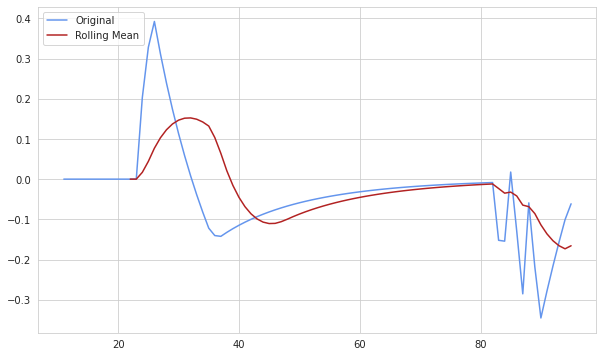


ADF Statistic: -3.231
p-value: 0.018
------------------------------------
Critical Values:
1%: -3.514
5%: -2.898
10%: -2.586
------------------------------------
ADF < Critical Values
Reject null hypothesis, time series is stationary.


In [16]:
adfuller_test(data_lsma_sub_data_lsma_ed, window = 12)

## <h3><b>ACF & PACF</b></h1>

Time series analysis and forecasting frequently make use of autocorrelation and partial autocorrelation plots.

These graphs illustrate the degree to which an observation in a time series is correlated with observations made at earlier time steps.

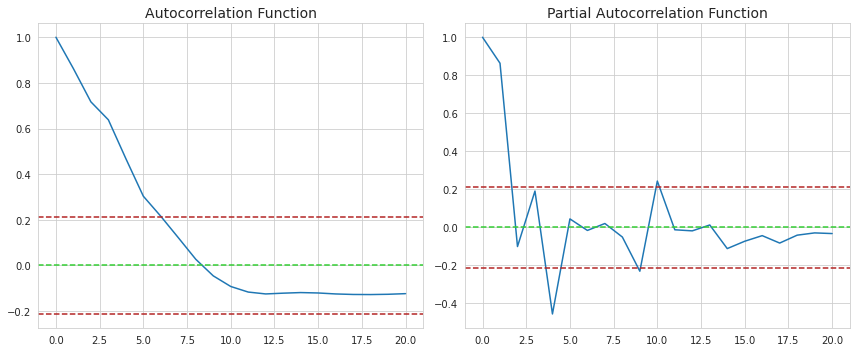

In [17]:
auto_c_f = acf(data_lsma_sub_data_lsma_ed, nlags=20)
partial_auto_c_f = pacf(data_lsma_sub_data_lsma_ed, nlags=20, method='ols')

fig, axs = plt.subplots(1, 2, figsize =(12,5))

plt.subplot(121)
plt.plot(auto_c_f)
plt.axhline(y=0, linestyle='--', color='limegreen')
plt.axhline(y=-1.96/np.sqrt(len(data_lsma_sub_data_lsma_ed)),
            linestyle='--', color='firebrick')
plt.axhline(y=1.96/np.sqrt(len(data_lsma_sub_data_lsma_ed)),
            linestyle='--', color='firebrick')
plt.title('Autocorrelation Function', size = 14)            

plt.subplot(122)
plt.plot(partial_auto_c_f)
plt.axhline(y=0, linestyle='--', color='limegreen')
plt.axhline(y=-1.96/np.sqrt(len(data_lsma_sub_data_lsma_ed)),
            linestyle='--', color='firebrick')
plt.axhline(y=1.96/np.sqrt(len(data_lsma_sub_data_lsma_ed)),
            linestyle='--', color='firebrick')
plt.title('Partial Autocorrelation Function', size = 14)
            
plt.tight_layout() 

## <h3><b>Prediction Models</b></h3>

<h5>Persistence Model</h5>

Let's imagine we want to create a model that, given all previous observations, can predict the last 10 blocks' power production values of the dataset's electric generation. Persisting the most recent observation would be the most basic model we might employ to generate predictions. This model, which we might refer to as a persistence model, offers a baseline of performance for the issue that we can compare to an autoregression model.

In [18]:
values = DataFrame(data_lsma_sub_data_lsma_ed.values)
persistence_df = concat([values.shift(1), values], axis=1)
persistence_df.columns = ['t-1', 't+1']
per_values = persistence_df.values

train = per_values[1:len(per_values)-10] 
test = per_values[len(per_values)-10:]

X_train, y_train = train[:,0], train[:,1]
X_test, y_test = test[:,0], test[:,1]

def persistence(x):
    return x

predictions = []
for i in X_test:
    y_pred = persistence(i)
    predictions.append(y_pred)

persistence_score = mean_squared_error(y_test, predictions)
print('Persistence MSE: {}'.format(round(persistence_score,4)))

Persistence MSE: 0.0155


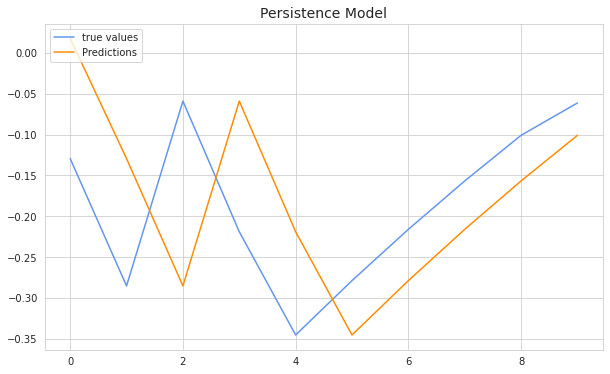

In [19]:
plt.figure(figsize = (10,6))
plt.plot(y_test, label = "true values", color = "cornflowerblue")
plt.plot(predictions,label = "Predictions", color='darkorange')
plt.title("Persistence Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()

## <h3><b>Autoregression Model</b></h3>

A linear regression model that incorporates lagged data as input variables is known as an autoregression model.

Using the LinearRegession class in scikit-learn, we could manually construct the linear regression model and provide the lag input variables to utilise.

The statsmodels package also trains a linear regression model and offers an autoregression model where you must supply an acceptable lag value. It is accessible through the AutoReg class.

In [22]:
ar_values = data_lsma_sub_data_lsma_ed.values
train = ar_values[1:len(ar_values)-10] 
test = ar_values[len(ar_values)-10:]
model = ARIMA(train, order=(2,1,0))
AR_model = model.fit()

predictions = AR_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
ar_score = mean_squared_error(test, predictions)
print('AR MSE: {}'.format(round(ar_score,4)))

AR MSE: 0.0946


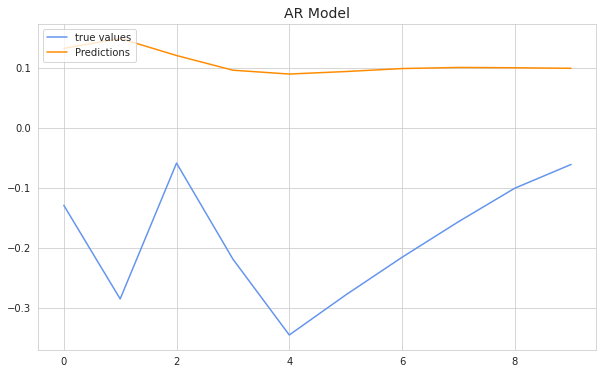

In [23]:
plt.figure(figsize = (10,6))
plt.plot(test, label = "true values", color = "cornflowerblue")
plt.plot(predictions,label = "Predictions", color='darkorange')
plt.title("AR Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()

## <h3><b>Moving Average Model</b></h3>

In [24]:
model = ARIMA(train, order=(0,1,2))
MA_model = model.fit()

predictions = MA_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
ma_score = mean_squared_error(test, predictions)
print('MA MSE: {}'.format(round(ma_score,4)))

MA MSE: 0.1578


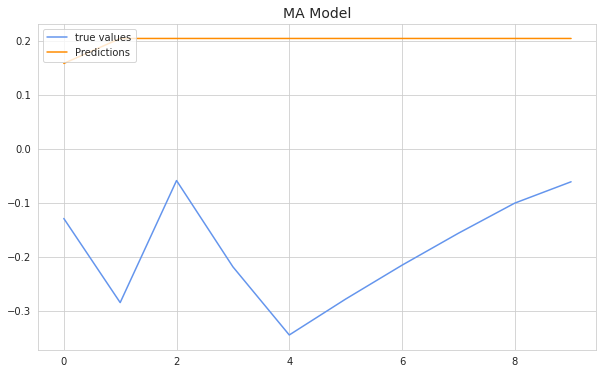

In [25]:
plt.figure(figsize = (10,6))
plt.plot(test, label = "true values", color = "cornflowerblue")
plt.plot(predictions,label = "Predictions", color='darkorange')
plt.title("MA Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()

## <h3><b>ARIMA Model</b></h3>
An ARIMA model may be fitted using the statsmodels package.

The statsmodels package may be used to build an ARIMA model as follows:

1. Call ARIMA() and pass the **p, d, and q** parameters to define the model.
2. The fit() method is used to prepare the model using the training data.
3. Calling the predict() method with the index of the time or times to be forecasted will provide a prediction.

Let's begin with something straightforward. We will analyse the complete dataset for Electric Production using an ARIMA model.

In [26]:
model = ARIMA(train, order=(2,1,2))
ARIMA_model = model.fit()

predictions = ARIMA_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
arima_score = mean_squared_error(test, predictions)
print('ARIMA MSE: {}'.format(round(arima_score,4)))

ARIMA MSE: 0.111


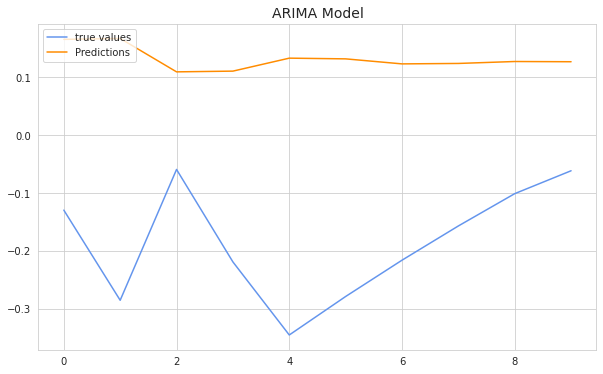

In [27]:
plt.figure(figsize = (10,6))
plt.plot(test, label = "true values", color = "cornflowerblue")
plt.plot(predictions,label = "Predictions", color='darkorange')
plt.title("ARIMA Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()

## <h3><b>Mean Squared Error</b></h3>

In [28]:
errors = pd.DataFrame()
errors["Model"] = ["Persistence", "Autoregression", "Moving Average", "ARIMA"]
errors["MSE"] = [persistence_score, ar_score, ma_score, arima_score]
errors = errors.sort_values("MSE", ascending = True, ignore_index = True)
errors.index = errors.Model
del errors["Model"]

def coloring_bg(s, min_, max_, cmap='Reds', low=0, high=0):
    color_range = max_ - min_
    norm = colors.Normalize(min_ - (color_range * low), max_ + (color_range * high))
    normed = norm(s.values)
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    return ['background-color: %s' % color for color in c]

errors.style.apply(coloring_bg,min_ =errors.min().min(),
               max_ = errors.max().max(), low = 0.1, high = 0.85)

,MSE
Model,
Persistence,0.015525
Autoregression,0.094622
ARIMA,0.111008
Moving Average,0.157764


In [29]:
# Lets have a look to the predicted values

predictions

array([0.16596171, 0.16751943, 0.10976177, 0.1110285 , 0.13345898,
       0.13223883, 0.12355145, 0.12430786, 0.1276633 , 0.12726021])

In [30]:
# As now we have stored our predicted values
# above , it's time for evaluation metrics to come into the 
# scene

from sklearn import metrics

# Get the root mean squared error (RMSE) for ARIMA Model
rmse = np.sqrt(arima_score)
print("ARIMA Model RMSE : ",rmse)

# Get r2 score for RNN Model
r2_rnn = metrics.r2_score(test, predictions)
print("ARIMA Model r2: ", r2_rnn)

ARIMA Model RMSE :  0.3331780365528068
ARIMA Model r2:  -11.49937439667004


In [31]:
# The prediction values we got are still transformed
# Thus, we have to apply inverse transformation to get the 
# original values

predictions = inv_boxcox(predictions, 0.0)

In [32]:
df_actual_values = df_power['UNCHAHAR4'][86:96].copy()
df_actual_values

86    385.930000
87    313.930000
88    385.939821
89    313.930000
90    257.810000
91    257.810000
92    257.810000
93    257.810000
94    257.810000
95    257.810000
Name: UNCHAHAR4, dtype: float64

In [33]:
print(type(df_actual_values))

<class 'pandas.core.series.Series'>


In [34]:
df_actual_values = list(df_actual_values)
df_actual_values

[385.93,
 313.93,
 385.939821,
 313.93,
 257.81,
 257.81,
 257.81,
 257.81,
 257.81,
 257.81]

In [35]:
df_actual_values = np.array(df_actual_values)
df_actual_values

array([385.93    , 313.93    , 385.939821, 313.93    , 257.81    ,
       257.81    , 257.81    , 257.81    , 257.81    , 257.81    ])

In [36]:
Actual_Prediction_Values = np.multiply(df_actual_values, predictions)
Actual_Prediction_Values

array([455.60112982, 371.18086788, 430.71353769, 350.79377998,
       294.61866433, 294.2594056 , 291.71413469, 291.93487218,
       292.91608712, 292.79803899])

In [37]:
# Lets put it in a more visually attractive & understandable manner

valid = df_power[86:96]
valid['Predictions_(ARIMA)'] = Actual_Prediction_Values
valid['Time Desc'] = df_power['Time Desc'][86:96]
valid[['Time Desc' , 'UNCHAHAR4' , 'Predictions_(ARIMA)']]

,Time Desc,UNCHAHAR4,Predictions_(ARIMA)
86,21:30-21:45,385.930000,455.601130
87,21:45-22:00,313.930000,371.180868
88,22:00-22:15,385.939821,430.713538
89,22:15-22:30,313.930000,350.793780
90,22:30-22:45,257.810000,294.618664
91,22:45-23:00,257.810000,294.259406
92,23:00-23:15,257.810000,291.714135
93,23:15-23:30,257.810000,291.934872
94,23:30-23:45,257.810000,292.916087
95,23:45-24:00,257.810000,292.798039


In [38]:
# Now , our main motive is to predict the demand OR the power
# to be generated for 10 blocks of next day

In [39]:
len (test)

10

In [40]:
predict_test_data = test[:, 0].reshape((-1))

In [54]:
def predict(num_prediction , model):
  prediction_list = predict_test_data[:]

  for _ in range(num_prediction-1):
    x = prediction_list[:]
    # x = x.reshape((1,10,1))
    out = ARIMA_model.predict()[0]
    prediction_list = np.append(prediction_list , out)
  prediction_list = prediction_list[:]

  return prediction_list

num_prediction = 10
forecast_next_day = predict(num_prediction,model)

In [55]:
forecast_next_day

array([-0.12942015, -0.28531759, -0.05905403, -0.21898986, -0.34536364,
       -0.27879997, -0.21601409, -0.15678796, -0.10091651, -0.06131603,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ])

In [56]:
forecast_next_day = forecast_next_day[:10]
forecast_next_day

array([-0.12942015, -0.28531759, -0.05905403, -0.21898986, -0.34536364,
       -0.27879997, -0.21601409, -0.15678796, -0.10091651, -0.06131603])

In [57]:
forecast_next_day = inv_boxcox(forecast_next_day, 0.0)
forecast_next_day

array([0.87860474, 0.75177546, 0.94265584, 0.80332986, 0.70796286,
       0.75669125, 0.80572395, 0.85488531, 0.90400851, 0.94052595])

In [58]:
a = df_power['UNCHAHAR4'][0:10]
a = np.array(a)
Actual_Prediction_Next_Day = np.multiply(forecast_next_day, a)

In [59]:
Actual_Prediction_Next_Day

array([226.51308751, 193.81523165, 243.02610121, 207.10647182,
       182.51990482, 195.08257033, 207.72369095, 220.39798232,
       233.06243339, 242.47699645])

In [65]:
# Let us save this numpy array in a text file for later comparsion

np.savetxt("drive/Othercomputers/My Laptop/CAPSTONE PROJECT/Forecast_ARIMA.txt", Actual_Prediction_Next_Day)

In [60]:
Actual_Prediction_Next_Day = np.reshape(Actual_Prediction_Next_Day , (10,1))
Actual_Prediction_Next_Day

array([[226.51308751],
       [193.81523165],
       [243.02610121],
       [207.10647182],
       [182.51990482],
       [195.08257033],
       [207.72369095],
       [220.39798232],
       [233.06243339],
       [242.47699645]])

In [61]:
Predicted_df = pd.DataFrame(Actual_Prediction_Next_Day, columns = ['UNCHAHAR4'], index = (range(1,11)))
Predicted_df

,UNCHAHAR4
1,226.513088
2,193.815232
3,243.026101
4,207.106472
5,182.519905
6,195.082570
7,207.723691
8,220.397982
9,233.062433
10,242.476996


In [62]:
new_time_desc = df_power['Time Desc'][:10]
new_time_desc

0    00:00-00:15
1    00:15-00:30
2    00:30-00:45
3    00:45-01:00
4    01:00-01:15
5    01:15-01:30
6    01:30-01:45
7    01:45-02:00
8    02:00-02:15
9    02:15-02:30
Name: Time Desc, dtype: object

In [63]:
new_time_desc = np.asarray(new_time_desc)
new_time_desc

array(['00:00-00:15', '00:15-00:30', '00:30-00:45', '00:45-01:00',
       '01:00-01:15', '01:15-01:30', '01:30-01:45', '01:45-02:00',
       '02:00-02:15', '02:15-02:30'], dtype=object)

## &nbsp;
## Power Generation for initial 10 blocks of Next Day

In [64]:
Predicted_df.insert(0,"Time Desc",new_time_desc,True)
Predicted_df

,Time Desc,UNCHAHAR4
1,00:00-00:15,226.513088
2,00:15-00:30,193.815232
3,00:30-00:45,243.026101
4,00:45-01:00,207.106472
5,01:00-01:15,182.519905
6,01:15-01:30,195.082570
7,01:30-01:45,207.723691
8,01:45-02:00,220.397982
9,02:00-02:15,233.062433
10,02:15-02:30,242.476996
